In [1]:
%matplotlib inline
import os
import re
import numpy as np
import scipy.io as sio
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from aesthetics import params
from matplotlib import colors
import matplotlib.ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itca import bidict, itca
from itca.utils import compute_hamming_distance, compute_y_dist
mpl.rcParams.update(params)
# mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')
# params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
# plt.rcParams.update(params)

In [2]:
#============================= Help functions =========================
def before_combine(p1, p2):
    a1 = p1  / (p1 + p2)
    a2 = p2  / (p1 + p2)
    # a1 = a1 / 2
    # a2 = a2 / 2
    return - a1 * p1 * np.log(p1) - a2 * p2 * np.log(p2)


def after_combine(p1, p2):
    return - (p1 + p2) * np.log(p1 + p2)


def before_combine_acc(pi, pj, sigma, d):
    p_max = max(pi, pj)
    offset = sigma**2 * np.log(p_max / (1 - pi - pj)) / np.sqrt(d)
    return norm.cdf(np.sqrt(d) / 2 + offset), norm.cdf(np.sqrt(d) / 2 - offset)


def after_combine_acc(pi, pj, sigma, d):
    offset = sigma**2 * np.log((pi + pj) / (1 - pi - pj)) / np.sqrt(d)
    return norm.cdf(np.sqrt(d) / 2 + offset), norm.cdf(np.sqrt(d) / 2 - offset)


def itca_diff_lda(p1, p2, sigma, d):
    p3 = 1 - p1 - p2
    before_acc, before_acc3 = before_combine_acc(p1, p2, sigma, d)
    after_acc, after_acc3 = after_combine_acc(p1, p2, sigma, d)
    before_itca =  - max(p1, p2) * np.log(max(p1, p2)) * before_acc  - p3 * np.log(p3) * before_acc3
    after_itca = - (p1 + p2) * np.log(p1 + p2) * after_acc  - p3 * np.log(p3) * after_acc3
    return after_itca - before_itca

In [3]:
n_points = 1000
p1_arr = np.linspace(0.001, 0.998, n_points)
canvas = np.zeros([n_points, n_points])
for i in range(n_points):
    p1 = p1_arr[i] 
    for j in range(1, n_points - i):
        p2 = p1_arr[j]
        canvas[i, j] = after_combine(p1, p2) - before_combine(p1, p2)

canvas2 = np.zeros([n_points, n_points])
for i in range(n_points):
    p1 = p1_arr[i]
    for j in range(1, n_points - i):
        p2 = p1_arr[j]
        if 1 - p1 - p2 > 0:
            p_max = max(p1, p2)
            canvas2[i, j] = -(p1 + p2) * np.log(p1 + p2) + max(p1, p2) * np.log(max(p1, p2))

In [104]:
area1_ratio = (np.sum(canvas > 0) / canvas.size) * 2
area1_ratio

0.275398

In [103]:
area2_ratio = (np.sum(canvas2 > 0) / canvas2.size) * 2
area2_ratio

0.182008

## Figure 11: $\Delta \text{p-ITCA}$ with $S=\{1, 2\}$ of the oracle classifier (left) and LDA (right).

In [3]:
from matplotlib.colors import LinearSegmentedColormap


def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]


def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

def get_bad_canvas(canvas):
    canvas_with_bad = np.copy(canvas)
    mask = np.ones(canvas.shape) - np.flip(np.tril(np.ones(canvas.shape)), axis=0)
    canvas_with_bad[np.nonzero(mask)] = np.nan
    return canvas_with_bad

def plot_curves(ax, canvas, p1_arr, color="#7b3294", marker=",", markersize=0, th=1e-3, linewidth=0):
    canvas_curves = np.abs(canvas + np.flip(np.triu(np.ones(canvas.shape)), axis=0)) <th
    curves_indices = np.nonzero(canvas_curves)
    ax.plot(p1_arr[curves_indices[0]], p1_arr[curves_indices[1]],  marker=marker, 
            linestyle="",  linewidth=linewidth, color=color, markersize=markersize)
    return ax
    

hex_list = ['#fc8d59','#ffffbf','#91bfdb']
my_cmp = get_continuous_cmap(hex_list)

In [59]:
canvas_with_bad = np.copy(canvas)
mask = np.ones(canvas.shape) - np.flip(np.tril(np.ones(canvas.shape)), axis=0)
canvas_with_bad[np.nonzero(mask)] = np.nan

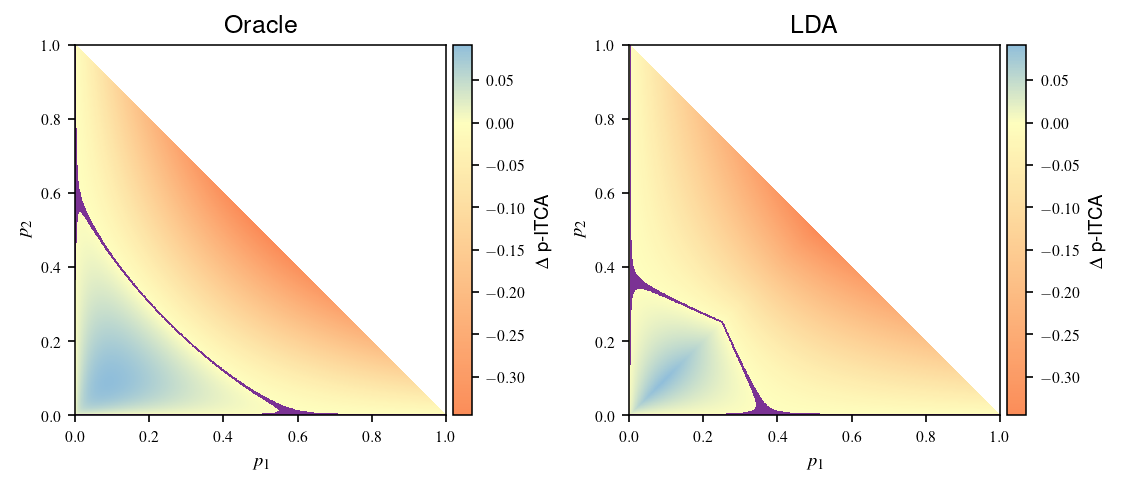

In [155]:
n_points = 1000
p1_arr = np.linspace(0.001, 0.998, n_points)
fig, (ax1, ax2) = plt.subplots(1, 2)
# plt.set_cmap('myOrYlBu')
vmin = np.min(canvas)
vmax = np.max(canvas)
color_norm = colors.TwoSlopeNorm(vmin=min(vmin, -1e-4), vcenter=0, vmax=vmax)
# plot oracle
im = ax1.pcolormesh(p1_arr, p1_arr, get_bad_canvas(canvas), norm=color_norm, shading='auto', cmap=my_cmp)
plot_curves(ax1, canvas, p1_arr, markersize=1, linewidth=0)
ax1.set_aspect(1.0)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_xlabel("$p_1$")
ax1.set_ylabel("$p_2$")
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = fig.colorbar(im, cax=cax, orientation='vertical')
cb.set_label("$\Delta$ p-ITCA")
ax1.set_title("Oracle", fontsize=12)
# plot LDA
im = ax2.pcolormesh(p1_arr, p1_arr, get_bad_canvas(canvas2), norm=color_norm, shading='auto', cmap=my_cmp)
plot_curves(ax2, canvas2, p1_arr, markersize=2, linewidth=0)
ax2.set_aspect(1.0)
ax2.set_xlabel("$p_1$")
ax2.set_ylabel("$p_2$")
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_title("LDA", fontsize=12)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = fig.colorbar(im, cax=cax, orientation='vertical')
cb.set_label("$\Delta$ p-ITCA")
fig.set_size_inches(7.5, 3.75)
plt.tight_layout()
plt.savefig("delta_p-ITCA.png", dpi=300)

In [315]:
print("p-ITCA oracle: red area ratio: {:.4f}".format(compute_area_ratio(canvas)))
print("p-ITCA LDA: red area ratio: {:.4f}".format(compute_area_ratio(canvas2)))

p-ITCA oracle: red area ratio: 0.2761
p-ITCA LDA: red area ratio: 0.1825


## Figure 12: $\Delta \text{s-ITCA}$ with $K_0=3$, $S=\{1, 2\}$ of LDA (middle panel) and the soft LDA (right panel).

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.special import softmax, expit
from tqdm import tqdm
from itca.simulation_suites import lda_suite
from itca.search import GreedySearch
from itca.metrics import itca
from itertools import product

def vectorized(prob_matrix, items):
    s = prob_matrix.cumsum(axis=1)
    r = np.random.rand(prob_matrix.shape[0])
    k = (s < r[:, np.newaxis]).sum(axis=1)
    return items[k]

class SoftLDA(LinearDiscriminantAnalysis):
    def predict(self, X):
        score = self.decision_function(X)
        if self.classes_.size == 2:
            proba = expit(score)
            prob_matrix = np.vstack([1-proba, proba]).T
        else:
            if score.ndim == 1:
                return np.zeros(X.shape[0], dtype=int)
            prob_matrix = softmax(score, axis=1)
        
        vals = np.arange(X.shape[0],dtype=int)
        y_pred = vectorized(prob_matrix, vals)
        return y_pred
    
def split_class(y, label, prop=0.5, seed=None):
    np.random.seed(seed)
    ind = y == label
    yi = y[ind]
    yi[np.random.rand(yi.shape[0]) <= prop] = np.max(y) + 1
    y_ = np.copy(y)
    y_[ind] = yi
    return y_  

def compute_hamming_dist(bv1, bv2):
    assert(len(bv1) == len(bv2))
    a = [bv1[i] == bv2[i] for i in range(len(bv1))]
    return len(bv1) - np.sum(a)

    
def mapping2bv(mapping):
    bv = [int(mapping[i] != mapping[i-1]) for i in range(1, len(mapping))]
    return "".join(str(b) for b in bv)

def compute_diff(X, y_obs, y_true, clf, id_mapping, true_mapping, y_dist):
    clf.fit(X, y_obs)
    prior = itca(y_obs, clf.predict(X), id_mapping, y_dist)
    clf.fit(X, y_true)
    post = itca(y_obs, clf.predict(X), true_mapping, y_dist)
    return post - prior

In [39]:
# it takes around 20min 
n_points = 100
protect = 0.1
p1_arr = np.linspace(0.1, 0.7, n_points)
n_samples = 5000
repeat = 5
canvas_hard = np.zeros([n_points, n_points])
canvas_soft = np.zeros([n_points, n_points])
lda = LinearDiscriminantAnalysis()
soft_lda = SoftLDA()
id_mapping = bidict({0:0, 1:1, 2:2})
true_mapping = bidict({0:0, 1:1, 2:1})
for i, j in tqdm(product(range(len(p1_arr)), range(len(p1_arr))), total=n_points**2):
        p1 = p1_arr[i]
        p2 = p1_arr[j]
        ni = int(n_samples * (1 - p1 - p2))
        if ni > protect * n_samples:
            hard_diff_v = []
            soft_diff_v = []
            for iter_i in range(repeat):
                sim_data = lda_suite(np.array([ni, int((p1 + p2) * n_samples)]), p=4, 
                             n_classes=2, length=5, seed=iter_i, min_dist=1)
                X = sim_data.X.T
                y_true = sim_data.y
                y_obs = split_class(sim_data.y, 1, prop=p1 / (p1 + p2))
                y_dist = compute_y_dist(y_obs)
                hard_diff = compute_diff(X, y_obs, y_true, lda, id_mapping, true_mapping, y_dist)
                soft_diff = compute_diff(X, y_obs, y_true, soft_lda, id_mapping, true_mapping, y_dist)
                hard_diff_v.append(hard_diff)
                soft_diff_v.append(soft_diff)
            canvas_hard[i, j] = np.mean(hard_diff_v)
            canvas_soft[i, j] = np.mean(soft_diff_v) 

100%|██████████| 10000/10000 [13:56<00:00, 11.95it/s]


In [13]:
def compute_area_ratio(canvas):
    x_range, y_range = np.nonzero(canvas)
    n, p = np.max(x_range), np.max(y_range)
    return np.sum(canvas > 1e-5) / (n * p) * 2


def sampling_canvas(mat, sub_n, sub_p, k=3):
    x_range, y_range = np.nonzero(mat)
    n, p = np.max(x_range), np.max(y_range)
    x = []
    x_step = int(n / k)
    for i in range(k-1):
        x.append(np.random.choice(np.arange(i * x_step, (i + 1) * x_step - 1), int(sub_n / k), replace=False))
    x = np.concatenate(x)
    x = np.concatenate([x, np.random.choice(np.arange((k-1) * x_step, n), sub_n - x.size, replace=False)])
    y = []
    y_step = int(p / k)
    for i in range(k-1):
        y.append(np.random.choice(np.arange(i * y_step, (i + 1) * y_step - 1), int(sub_p / k) , replace=False))
    y = np.concatenate(y)
    y = np.concatenate([y, np.random.choice(np.arange((k-1) * y_step, p), sub_p - y.size, replace=False)])
    indices = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
    sub_mat = mat[indices[:, 0], indices[:, 1]]
    return sub_mat.reshape(sub_n, sub_p)

In [308]:
oracle_area = []
lda_area = []
for i in range(1000):
    oracle_area.append(compute_area_ratio(sampling_canvas(canvas1_sub, 100, 100)))
    lda_area.append(compute_area_ratio(sampling_canvas(canvas2_sub, 100, 100)))

In [314]:
print("Oracle resampling: {:.4f} ({:.4f})".format(np.mean(oracle_area), np.std(oracle_area)))
print("LDA resampling: {:.4f} ({:.4f})".format(np.mean(lda_area), np.std(lda_area)))

Oracle resampling: 0.2685 (0.0181)
LDA resampling: 0.1864 (0.0111)


In [239]:
n_points = 100
p1_arr = np.linspace(0.1, 0.7, n_points)
canvas = np.zeros([n_points, n_points])
for i in range(n_points):
    p1 = p1_arr[i] 
    for j in range(1, n_points - i):
        p2 = p1_arr[j]
        canvas[i, j] = after_combine(p1, p2) - before_combine(p1, p2)

canvas2 = np.zeros([n_points, n_points])
for i in range(n_points):
    p1 = p1_arr[i]
    for j in range(1, n_points - i):
        p2 = p1_arr[j]
        if 1 - p1 - p2 > 0:
            p_max = max(p1, p2)
            canvas2[i, j] = -(p1 + p2) * np.log(p1 + p2) + max(p1, p2) * np.log(max(p1, p2))

In [46]:
def compute_area_ratio(canvas):
    x_range, y_range = np.nonzero(canvas)
    n, p = np.max(x_range), np.max(y_range)
    print(n * p)
    return np.sum(canvas > 1e-5) / (n * p) * 2

print("p-ITCA oracle: red area ratio: {:.4f}".format(compute_area_ratio(canvas1_sub)))
print("p-ITCA LDA: red area ratio: {:.4f}".format(compute_area_ratio(canvas2_sub)))
print("LDA: red area ratio: {:.4f}".format(compute_area_ratio(canvas_hard)))
print("soft-LDA: red area ratio: {:.4f}".format(compute_area_ratio(canvas_soft)))

361201
p-ITCA oracle: red area ratio: 0.2658
361201
p-ITCA LDA: red area ratio: 0.1836
9801
LDA: red area ratio: 0.1877
9801
soft-LDA: red area ratio: 0.2720


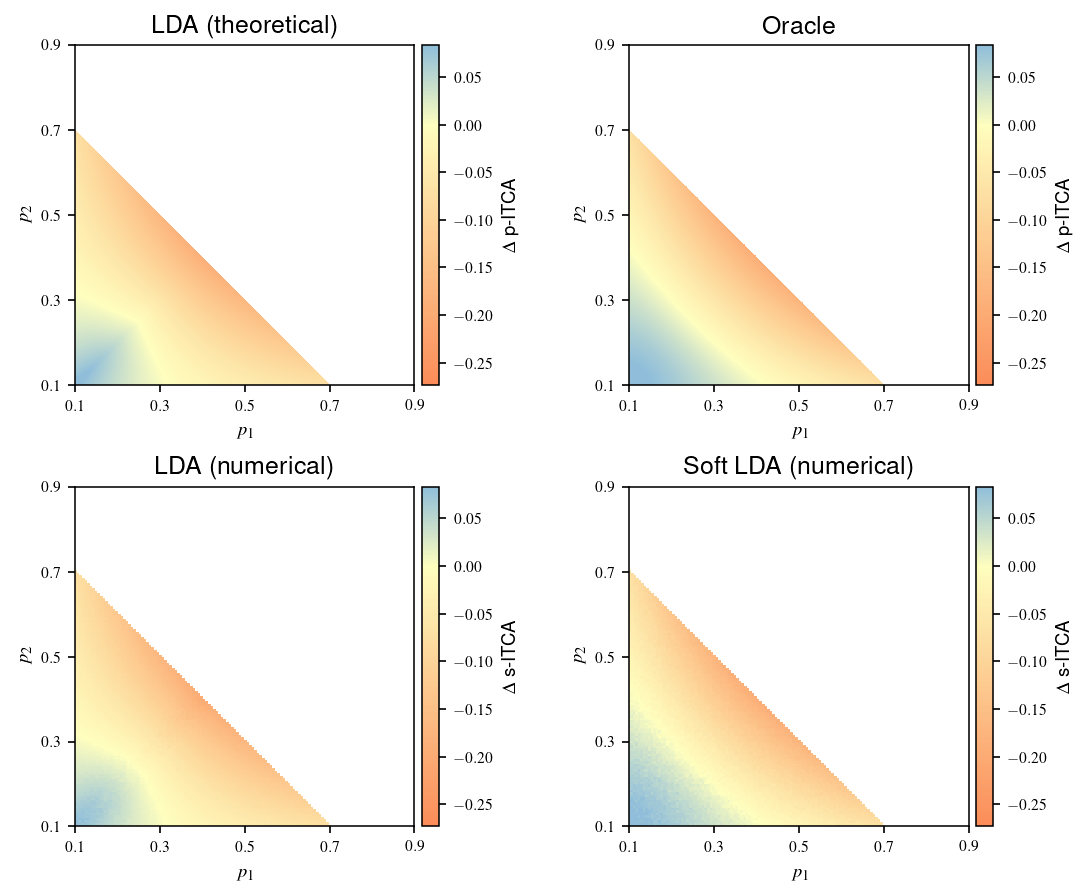

In [45]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
vmin = min(np.min(canvas_hard), np.min(canvas_soft))
vmax = np.max(canvas_hard)
color_norm = matplotlib.colors.TwoSlopeNorm(vmin=min(vmin, -1e-4), vcenter=0, vmax=vmax)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
# subset  theoretical resutls
p1_arr = np.linspace(0.001, 0.998, 1000)
ind_end = np.argmin(np.abs(p1_arr - 0.7))
ind_start = np.argmin(np.abs(p1_arr - 0.1))
canvas1_sub = canvas[ind_start:ind_end+1, ind_start:ind_end+1]
canvas2_sub = canvas2[ind_start:ind_end+1, ind_start:ind_end+1]
p1_arr_sub = p1_arr[ind_start:ind_end+1]
mask = np.flip(np.tril(np.ones(canvas2_sub.shape)), axis=0)
canvas1_sub = np.multiply(canvas1_sub, mask)
canvas2_sub = np.multiply(canvas2_sub, mask)
# subset experimental results
# p1_arr = np.linspace(0.1, 0.9, 100)
# ind_end = np.argmin(np.abs(p1_arr - 0.8))
#ind_start = np.argmin(np.abs(p1_arr - 0.1))
# p1_arr_sub = p1_arr[ind_start:ind_end+1]
# canvas_hard_sub = canvas_hard[ind_start:ind_end+1, ind_start:ind_end+1]
# canvas_soft_sub = canvas_soft[ind_start:ind_end+1, ind_start:ind_end+1]
#-------------------------------  Plot p-ITCA for comparision -----------------------------------
# im0 = ax0.pcolormesh(np.linspace(0.001, 0.7, 1000), np.linspace(0.001, 0.7, 1000),  canvas2, 
#                      norm=colors.TwoSlopeNorm(vmin=-0.18, vcenter=0, vmax=0.08),
#                      shading='auto')
#--------------------------------------- Oracle ---------------------------------------
canvas_list = [get_bad_canvas(canvas2_sub), get_bad_canvas(canvas1_sub), 
               get_bad_canvas(canvas_hard), get_bad_canvas(canvas_soft)]
title_list = ["LDA (theoretical)", "Oracle", "LDA (numerical)", "Soft LDA (numerical)"]
for ind, ax in enumerate([ax1, ax2, ax3, ax4]):
    if ind < 2:
        p1_arr = np.linspace(0.001, 0.998, 1000)
        ind_end = np.argmin(np.abs(p1_arr - 0.7))
        ind_start = np.argmin(np.abs(p1_arr - 0.1))
        p1_arr_sub = p1_arr[ind_start:ind_end+1]
    else:
        p1_arr_sub = np.linspace(0.1, 0.7, 100)
    x_range, y_range = p1_arr_sub, p1_arr_sub 
    im = ax.pcolormesh(x_range, y_range,  canvas_list[ind], 
                     norm=color_norm,  shading='auto', cmap=my_cmp)
    ax.set_aspect(1.0)
    ax.set_xlim([0.1, 0.9])
    ax.set_ylim([0.1, 0.9])
    ax.set_xticks([0.1, 0.3, 0.5, 0.7, 0.9])
    ax.set_yticks([0.1, 0.3, 0.5, 0.7, 0.9])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb = fig.colorbar(im, cax=cax, orientation='vertical')
    if ind < 2:
        cb.set_label("$\Delta$ p-ITCA")
    else:
        cb.set_label("$\Delta$ s-ITCA")
    ax.set_title(title_list[ind], fontsize=12)
    ax.set_xlabel("$p_1$")
    ax.set_ylabel("$p_2$")
       
fig.set_size_inches(7.5, 6)
plt.tight_layout()
plt.savefig("delta_ps-ITCA.png", dpi=300)